In [1]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 21.9 MB/s eta 0:00:01


In [2]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 110 kB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 287 kB 27.3 MB/s eta 0:00:01


In [3]:
train_file = "data/train_14k_split_conll.txt"
test_file = "data/dev_3k_split_conll.txt"

In [4]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 1.8 MB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 145 kB 29.3 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 26.3 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 37.0 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=c80dd883808464f598e355a6fce31259bfae5c1d8882c632d3aafa0878c3ae29
  Stored in directory: /tmp/pip-ephem-wheel-cache-dec7cr2e/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=e0b1449464d2ca5ce1a0ce7ec4d2a9f807ab52d2a4ff5f04c2f9da03b0efaa72
  Stored in directory: /tmp/pip-ephem-wheel-cache-dec7cr2e/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built promise pathtools


In [5]:
import re
import time
import string
import contractions
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import wandb
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from pathlib import Path

In [9]:
run = wandb.init(project="Sentiment Analysis-Hinglish", entity="alokpadhi")
raw_data = wandb.Artifact("Train-Test-Data", type="raw_data")
raw_data.add_dir(Path("data/"))
run.log_artifact(raw_data)

wandb: Adding directory to artifact (./data)... Done. 0.1s


In [25]:
# read the files
with open(train_file) as f:
    train_data = f.readlines()
    
with open(test_file, 'r') as f:
    test_data = f.readlines()

In [26]:
import random

In [29]:
# check the data
train_data[random.randint(0, len(train_data))]

'Bhai\tHin\n'

In [45]:
train_data[:30]

['meta\t4330\tneutral\n',
 'nen\tEng\n',
 'á\tO\n',
 'vist\tEng\n',
 'bolest\tEng\n',
 'vztek\tEng\n',
 'smutek\tEng\n',
 'zmatek\tHin\n',
 'osam\tHin\n',
 'ě\tO\n',
 'lost\tEng\n',
 'beznad\tEng\n',
 'ě\tO\n',
 'j\tHin\n',
 'a\tEng\n',
 'nakonec\tEng\n',
 'jen\tHin\n',
 'klid\tHin\n',
 'Asi\tHin\n',
 'takhle\tHin\n',
 'vypad\tHin\n',
 'á\tO\n',
 'm\tHin\n',
 'ů\tO\n',
 'j\tEng\n',
 'life\tEng\n',
 '...\tO\n',
 '\n',
 'meta\t41616\tneutral\n',
 '@\tO\n']

In [34]:
# Parse the data
def parse_data(data):
    sentences, sentences_info, sentiment = [], [], []
    all_langs = []
    
    single_sentence, single_sentence_info = [], []
    sent = ""
    
    for i, line in enumerate(data):
        line_ = line.strip()
        tokens = line_.split('\t')
        num_tokens = len(tokens)
        if num_tokens == 2:
            # add the word
            single_sentence.append(tokens[0])
            # add the language
            single_sentence_info.append(tokens[1])
            all_langs.append(tokens[1])
        elif num_tokens == 3 and i > 0:
            sentences.append(single_sentence)
            sentences_info.append(single_sentence_info)
            sentiment.append(sent)
            sent = tokens[-1]
            single_sentence = []
            single_sentence_info = []
        elif num_tokens == 1:
            continue
        else:
            sent = tokens[-1]
            
    if len(single_sentence) > 0:
        sentences.append(single_sentence)
        sentences_info.append(single_sentence_info)
        sentiment.append(sent)
        
    assert len(sentences) == len(sentences_info) == len(sentiment)
    return sentences, sentences_info, sentiment, all_langs

In [35]:
sentences, sentences_info, sentiment, all_langs = parse_data(train_data)

In [37]:
test_sentences, test_sentences_info, test_sentiment, test_all_langs = parse_data(test_data)

In [38]:
len(sentiment)

14000

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

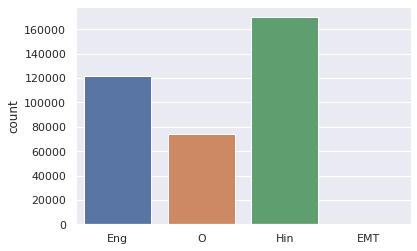

In [39]:
# Language count plot
sns.countplot(all_langs)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

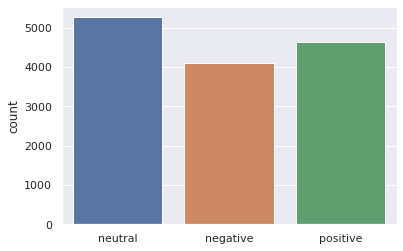

In [40]:
# sentiment count plot
sns.countplot(sentiment)

In [41]:
token_lengths = [len(sent) for sent in sentences]

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

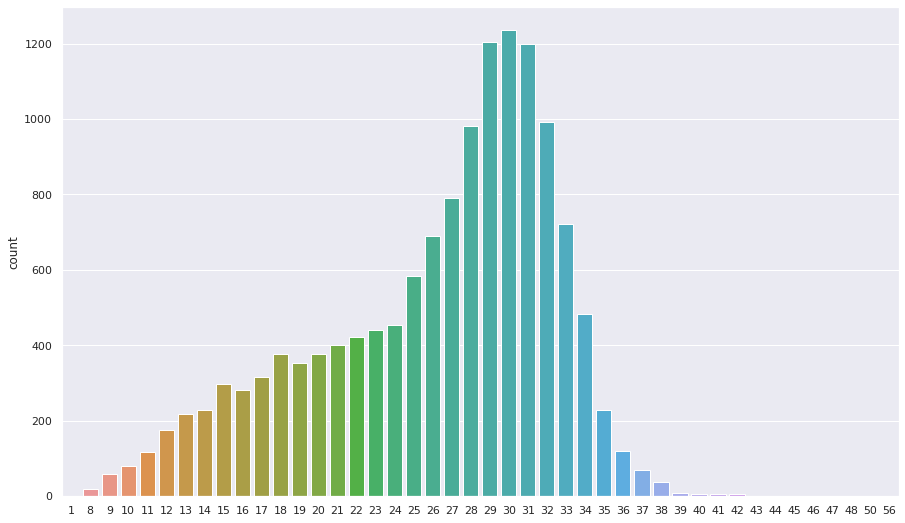

In [42]:
# sentence length distrubution
plt.figure(figsize=(15,9))
sns.countplot(token_lengths)

In [43]:
sentences[0]

['nen',
 'á',
 'vist',
 'bolest',
 'vztek',
 'smutek',
 'zmatek',
 'osam',
 'ě',
 'lost',
 'beznad',
 'ě',
 'j',
 'a',
 'nakonec',
 'jen',
 'klid',
 'Asi',
 'takhle',
 'vypad',
 'á',
 'm',
 'ů',
 'j',
 'life',
 '...']

In [52]:
a = re.sub("\sRT\s", "", "test RT ")
a

'test'

In [69]:
# Data Preprocessing
url_pattern = r'https(.*)/\s\w+'
names_with_numbers = r'([A-Za-z]+)\d{3,}'
apostee = r"([\w]+)\s'\s([\w]+)"
names = r"@[\s]*[\w]+[\s]*[_]+[\s]*[\w]+|@[\s]*[\w]+"

def preprocess_data(sentence_tokens):
    sentence = " ".join(sentence_tokens)
    sentence = " " + sentence
    
    # Remove RT and ...
    sentence = re.sub("\sRT\s", "", sentence)
    sentence = sentence.replace("…", "")
    sentence = re.sub(re.compile(names), " ", sentence)
    sentence = re.sub(re.compile(url_pattern), "", sentence)
    sentence = re.sub(re.compile(apostee), r"\1'\2", sentence)
    
    # fixing contractions
    sentence = contractions.fix(sentence)
    
    sentence = re.sub(re.compile(names_with_numbers), r" ", sentence)
    
    sentence = " ".join(sentence.split()).strip()
    return sentence

In [70]:
" ".join(sentences[1])

'@ nehantics Haan yaar neha 😔😔 kab karega woh post 😭 Usne na sach mein photoshoot karna chahiye phir woh post karega … https // tco / 5RSlSbZNtt'

In [71]:
preprocess_data(sentences[1])

'Haan yaar neha 😔😔 kab karega woh post 😭 Usne na sach mein photoshoot karna chahiye phir woh post karega'

In [72]:
# preprocess all training samples
processed_sentences = []
for sent in sentences:
    processed_sentences.append(preprocess_data(sent))

In [73]:
test_processed_sentences = []
for sent in test_sentences:
    test_processed_sentences.append(preprocess_data(sent))

In [74]:
sentiment_mapping = {
    "positive": 0,
    "negative": 1,
    "neutral": 2
}

In [75]:
labels = [sentiment_mapping[sent] for sent in sentiment]
test_labels = [sentiment_mapping[sent] for sent in test_sentiment]

In [76]:
# Create train and test dataframe with processed data for future use
assert len(processed_sentences) == len(labels) == len(sentiment)
train_dataset = list(zip(processed_sentences, sentiment, labels))

In [80]:
train_df = pd.DataFrame(train_dataset, columns=["Sentence", "Sentiment", "Sentence Label"])

In [81]:
train_df.head()

,Sentence,Sentiment,Sentence Label
0,nen á vist bolest vztek smutek zmatek osam ě l...,neutral,2
1,Haan yaar neha 😔😔 kab karega woh post 😭 Usne n...,neutral,2
2,television media congress ke liye nhi h . Ye t...,negative,1
3,All India me nrc lagu kare w Kashmir se dhara ...,positive,0
4,Pagal hai kya ? They aren ’ t real issues Mand...,neutral,2


In [83]:
# Create train and test dataframe with processed data for future use
assert len(test_processed_sentences) == len(test_labels) == len(test_sentiment)
test_dataset = list(zip(test_processed_sentences, test_sentiment, test_labels))

test_df = pd.DataFrame(test_dataset, columns=["Sentence", "Sentiment", "Sentence Label"])

test_df.head()

,Sentence,Sentiment,Sentence Label
0,modi mantrimandal may samil honay par badhai n...,positive,0
1,Tu toh naamakool hai Mare h,negative,1
2,YOU saw caste and religion in them ... nation ...,negative,1
3,sir local police station pe complaint krne par...,neutral,2
4,Ve Maahi song from # Kesari is current favouri...,positive,0


In [84]:
wandb.log({"Process Train Dataframe": wandb.Table(data=train_dataset, columns=["Sentence", "Sentiment", "Sentiment Label"])})

In [85]:
wandb.log({"Process Test Dataframe": wandb.Table(data=test_dataset, columns=["Sentence", "Sentiment", "Sentiment Label"])})

In [86]:
train_data, val_data, train_label, val_label = train_test_split(processed_sentences, labels, test_size=0.25)

In [87]:
print(f"Training sample size: {len(train_data)}\n Validation sample size: {len(val_data)}")

Training sample size: 10500
 Validation sample size: 3500


In [88]:
# Create the token vocab
counter = Counter()
for line in train_data:
    tokens = line.strip().split()
    counter.update(tokens)

In [89]:
vocab = []
for key in counter.most_common():
    if key[1] > 15:
        vocab.append(key[0])

In [90]:
len(vocab)

1466

In [91]:
print(vocab[:5])

['.', 'hai', 'ki', 'to', 'ko']


In [92]:
from sklearn.feature_extraction.text import CountVectorizer

In [229]:
vectorizer = CountVectorizer(min_df=15)

In [230]:
train_data[0]

'mujhe to nahi lagta koi darta hai . ye hi log hain jo Desh k logo ko darne or darane ki ra'

In [231]:
train_X = vectorizer.fit_transform(train_data)

In [232]:
train_X[0].shape

(1, 1331)

In [233]:
train_X.toarray().shape

(10500, 1331)

In [234]:
train_input = torch.FloatTensor(train_X.toarray())
train_input.shape

torch.Size([10500, 1331])

In [235]:
train_input[0].shape

torch.Size([1331])

In [236]:
val_X = torch.FloatTensor(vectorizer.transform(val_data).toarray())
test_X = torch.FloatTensor(vectorizer.transform(test_data).toarray())

In [237]:
# Pytorch dataset
class HinglishDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return [self.inputs[idx], self.labels[idx]]

In [238]:
train_dataset = HinglishDataset(train_input, train_label)
val_dataset = HinglishDataset(val_X, val_label)
test_dataset = HinglishDataset(test_X, test_labels)

In [239]:
train_dataset[0][0].shape

torch.Size([1331])

In [240]:
val_dataset[0][0].shape

torch.Size([1331])

In [241]:
test_dataset[0][0].shape

torch.Size([1331])

In [242]:
input_dim = len(vectorizer.get_feature_names())
output_dim = 3
hidden1_dim = 256
hidden2_dim = 128
epochs = 20

In [243]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [244]:
model = nn.Sequential(
    nn.Linear(input_dim, hidden1_dim),
    nn.ReLU(),
    nn.Linear(hidden1_dim, hidden2_dim),
    nn.ReLU(),
    nn.Linear(hidden2_dim, output_dim),
    nn.Softmax(dim=1)
)

In [245]:
model.to(device)

Sequential(
  (0): Linear(in_features=1331, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=3, bias=True)
  (5): Softmax(dim=1)
)

In [267]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [247]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, )
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [248]:
sample = next(iter(train_loader))

In [249]:
sample[0].shape

torch.Size([64, 1331])

In [250]:
sample[1].shape

torch.Size([64])

In [268]:
def train(iterator):
    epoch_loss = 0
    model.train()
    
    train_example_ct = 0  # number of examples seen
    train_batch_ct = 0
    
    for batch in iterator:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        
        train_example_ct +=  len(inputs)
        train_batch_ct += 1
        
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        
        if ((train_batch_ct + 1) % 15) == 0:
            print(f"Training Loss after " + str(train_example_ct).zfill(5) + f" examples: {loss:.3f}")
            wandb.log({"training_loss": loss}, step=train_example_ct)
            
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [252]:
def simple_accuracy(preds, labels):
    """Takes in two lists of predicted labels and actual labels and returns the accuracy in the form of a float. """
    return np.equal(preds, labels).mean()

In [262]:
def evaluate(iterator):
    epoch_loss = 0
    model.eval()
    preds = []
    trgs = []
    
    valid_example_ct = 0  # number of examples seen
    valid_batch_ct = 0
    
    with torch.no_grad():
        for batch in iterator:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch

            # forward + backward + optimize
            outputs = model(inputs.to(device))
            
            valid_example_ct +=  len(inputs)
            valid_batch_ct += 1
            
            loss = criterion(outputs, labels.to(device))
            
            epoch_loss += loss.item()
            trgs.extend(labels.numpy().tolist())
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().numpy().tolist())
            
            # Report metrics every 15th batch
            if ((valid_batch_ct + 1) % 15) == 0:
                print(f"Loss after (validating)" + str(valid_example_ct).zfill(5) + f" examples: {loss:.3f}")
                wandb.log({"validation_loss": loss}, step=valid_example_ct)
    
    return epoch_loss / len(iterator), simple_accuracy(preds, trgs)

In [263]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

In [264]:
model_path = Path("model/")
model_path.mkdir(parents=True, exist_ok=True)

In [269]:
with wandb.init(project="Sentiment Analysis-Hinglish") as run:
    wandb.watch(model, criterion, log="all", log_freq=10)
    
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        start_time = time.time()
        train_loss = train(train_loader)
        val_loss, val_acc = evaluate(val_loader)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s")
        print(f"\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            torch.save(model.state_dict(), Path(model_path, "multilayer_perceptron.pt"))
        
        model_artifact = wandb.Artifact(
          "MLP",type="model",description="MLP baseline model", metadata={"hidden_layer_dims": [256,128], "activation": "ReLU"})
        
        wandb.log({"epoch": epochs, "optimizer": "SGD"})
        model_artifact.add_file(Path(model_path, "multilayer_perceptron.pt"))
        run.log_artifact(model_artifact)

Training Loss after 00896 examples: 1.101
Training Loss after 01856 examples: 1.096
Training Loss after 02816 examples: 1.095
Training Loss after 03776 examples: 1.096
Training Loss after 04736 examples: 1.099
Training Loss after 05696 examples: 1.098
Training Loss after 06656 examples: 1.099
Training Loss after 07616 examples: 1.099
Training Loss after 08576 examples: 1.093
Training Loss after 09536 examples: 1.098
Training Loss after 10496 examples: 1.092
Loss after (validating)00896 examples: 1.096
Loss after (validating)01856 examples: 1.091
Loss after (validating)02816 examples: 1.101
Epoch: 01 | Time: 0m 3.96s
	Train Loss: 1.097 | Val Loss: 1.097 | Val Acc: 0.378
Training Loss after 00896 examples: 1.098
Training Loss after 01856 examples: 1.095
Training Loss after 02816 examples: 1.096
Training Loss after 03776 examples: 1.099
Training Loss after 04736 examples: 1.091
Training Loss after 05696 examples: 1.096
Training Loss after 06656 examples: 1.093
Training Loss after 07616 ex

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▄▃▄▇▅▆▇▂▆▁
epoch,20
optimizer,SGD
training_loss,1.09236
